# Generating choice sets


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)

For each vendor of interest:
Make a table representing full factorial experiment design.

With columns:

```
v (vendor type code)
v_type (vendor type value)
gc (ground vehicle delivery fee code)
g_cost (ground vehicle delivery fee value)
gt (ground vehicle delivery wait time code)
g_time (ground vehicle delivery wait time value)
dc (drone delivery fee code)
d_cost (drone delivery fee value)
dt (drone delivery wait time code)
d_time (drone delivery wait time value)
dp (drone privacy code)
drone privacy
```

Add in additional columns:

```
d_time - g_time
d_cost - g_cost
exclude (whether to exclude the choice because one option dominates)
sampled (whether choice included in random sample from non-excluded choices)
```

For each vendor, save the 100 sampled choices in a separate file.

`surveyv1-choices-vendor{vendor}-sampled-100.csv`

In [3]:
def get_data_records_for_vendor(v):
    v_type = VENDOR_TYPES[v][0]
    fees = COST_LEVELS[v]
    wait_times = TIME_LEVELS[v]
    drone_privacy = DRONE_PRIVACY_LEVELS
    print('get data records using vendor v%s: %s' % (v, v_type))
    print('delivery fees: %s' % fees)
    print('delivery wait times: %s' % wait_times)
    data_records = []
    for gc, g_cost in enumerate(fees):
        for gt, g_time in enumerate(wait_times):
            for dc, d_cost in enumerate(fees):
                for dt, d_time in enumerate(wait_times):
                    for dp, privacy in enumerate(drone_privacy):
                        data_record = {
                            'v': v,
                            'v_type': v_type,
                            # ground vehicle cost
                            'gc': gc,
                            'g_cost': g_cost[0],
                            # ground vehicle time
                            'gt': gt,
                            'g_time': g_time[0],
                            # drone cost
                            'dc': dc,
                            'd_cost': d_cost[0],
                            # drone time
                            'dt': dt,
                            'd_time': d_time[0],
                            # drone privacy: 0/1
                            'dp': dp,
                            'drone privacy': privacy[0]
                        }
                        data_records += [data_record]
    return data_records

In [8]:
# Make a big dataframe containing data for all of the vendors

df = None
for v, vendor_tuple in enumerate(VENDOR_TYPES):
    print('v%s' % v)
    if df is None:
        df = pd.DataFrame.from_records(get_data_records_for_vendor(v))
    else:
        df = df.append(pd.DataFrame.from_records(get_data_records_for_vendor(v)))
    print('%s total rows' % len(df))
df = df.reset_index().drop('index', axis=1)
df.head()

v0
get data records using vendor v0: take-out food
delivery fees: [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')]
delivery wait times: [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')]
512 total rows
v1
get data records using vendor v1: prescription medications
delivery fees: [(0, '$0'), (1, '$1'), (5, '$5'), (10, '$10')]
delivery wait times: [(30, '30 minutes'), (120, '2 hrs'), (360, '6 hrs'), (1440, '1 day')]
1024 total rows
v2
get data records using vendor v2: liquor store
delivery fees: [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')]
delivery wait times: [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')]
1536 total rows
v3
get data records using vendor v3: last-minute groceries
delivery fees: [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')]
delivery wait times: [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')]
2048 total rows


,v,v_type,gc,g_cost,gt,g_time,dc,d_cost,dt,d_time,dp,drone privacy
0,0,take-out food,0,0,0,15,0,0,0,15,0,0
1,0,take-out food,0,0,0,15,0,0,0,15,1,1
2,0,take-out food,0,0,0,15,0,0,1,20,0,0
3,0,take-out food,0,0,0,15,0,0,1,20,1,1
4,0,take-out food,0,0,0,15,0,0,2,30,0,0


Add in columns representing difference between choices w.r.t. 
- time (delivery wait time): drone wait time - ground vehicle wait time: dt - gt
- cost (delivery fee): drone fee - ground vehicle fee


In [9]:
df['d_time - g_time'] = df['d_time'] - df['g_time']
df['d_cost - g_cost'] = df['d_cost'] - df['g_cost']

In [10]:
df['exclude'] = False

In [16]:
def plot_points_tradeoff(df, vendor):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        ax.scatter(
            df_p['d_time - g_time'], df_p['d_cost - g_cost'],
            color='gray', marker='.'
        )
        if ('exclude' in df_p.columns):
            df_p_no_exclude = df_p[df_p['exclude'] == False]
            ax.scatter(
                df_p_no_exclude['d_time - g_time'],
                df_p_no_exclude['d_cost - g_cost'],
                color='gray', marker='o',
            )
        if ('sampled' in df_p.columns):
            df_p_sampled = df_p[df_p['sampled'] == True]
            ax.scatter(
                df_p_sampled['d_time - g_time'], 
                df_p_sampled['d_cost - g_cost'],
                color='black', marker='o',
            )
            
        ax.set_xlabel('drone wait time - ground vehicle wait time (mins)')
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)


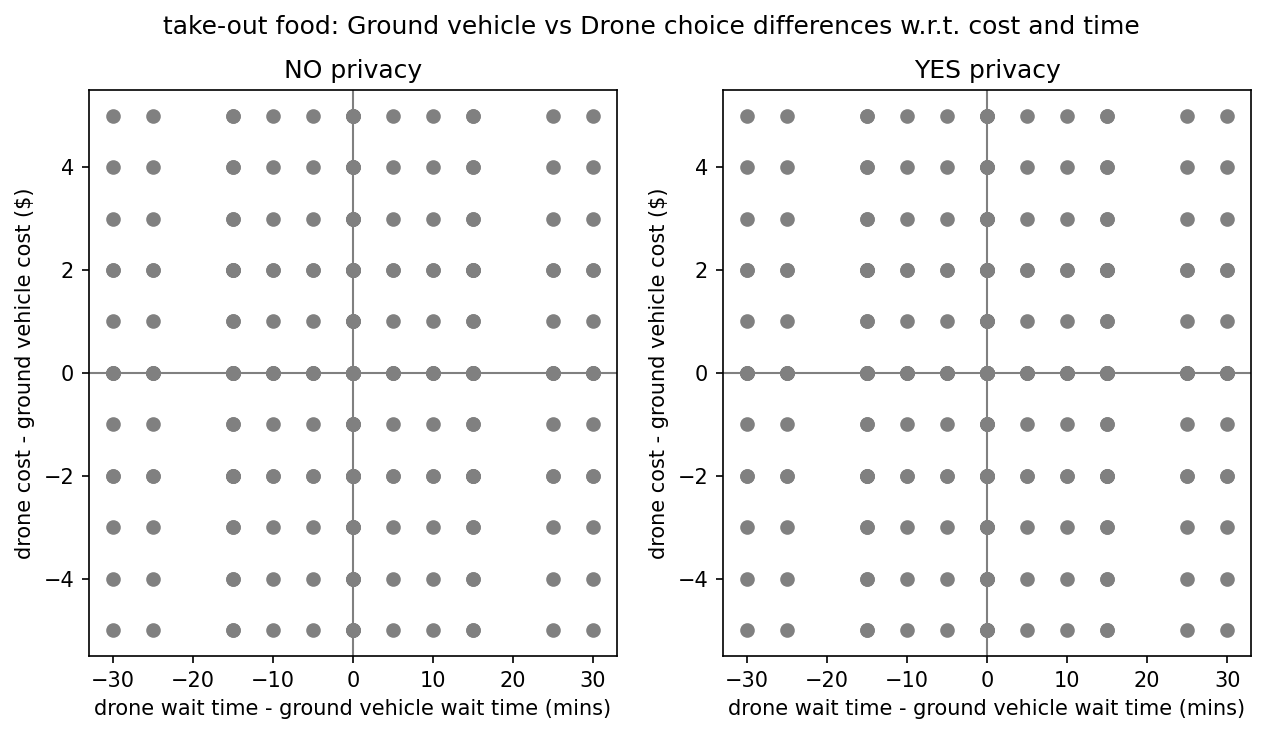

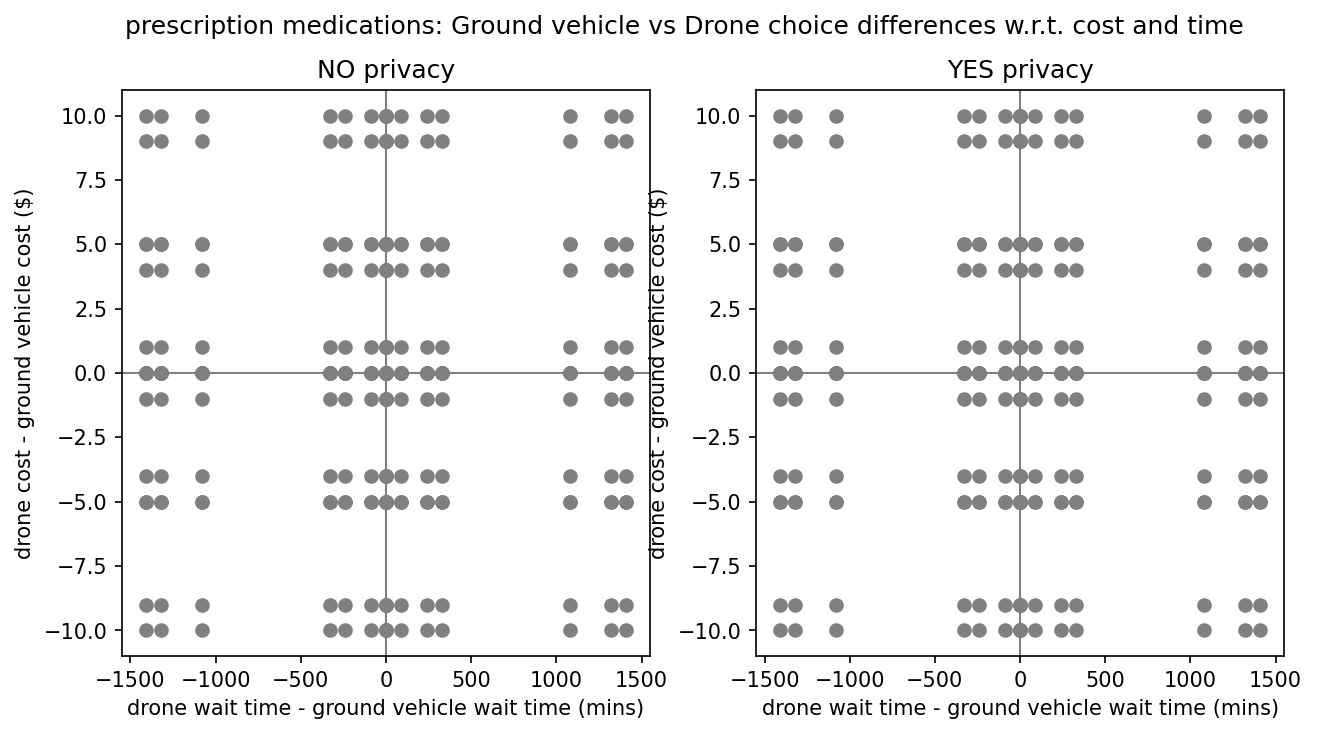

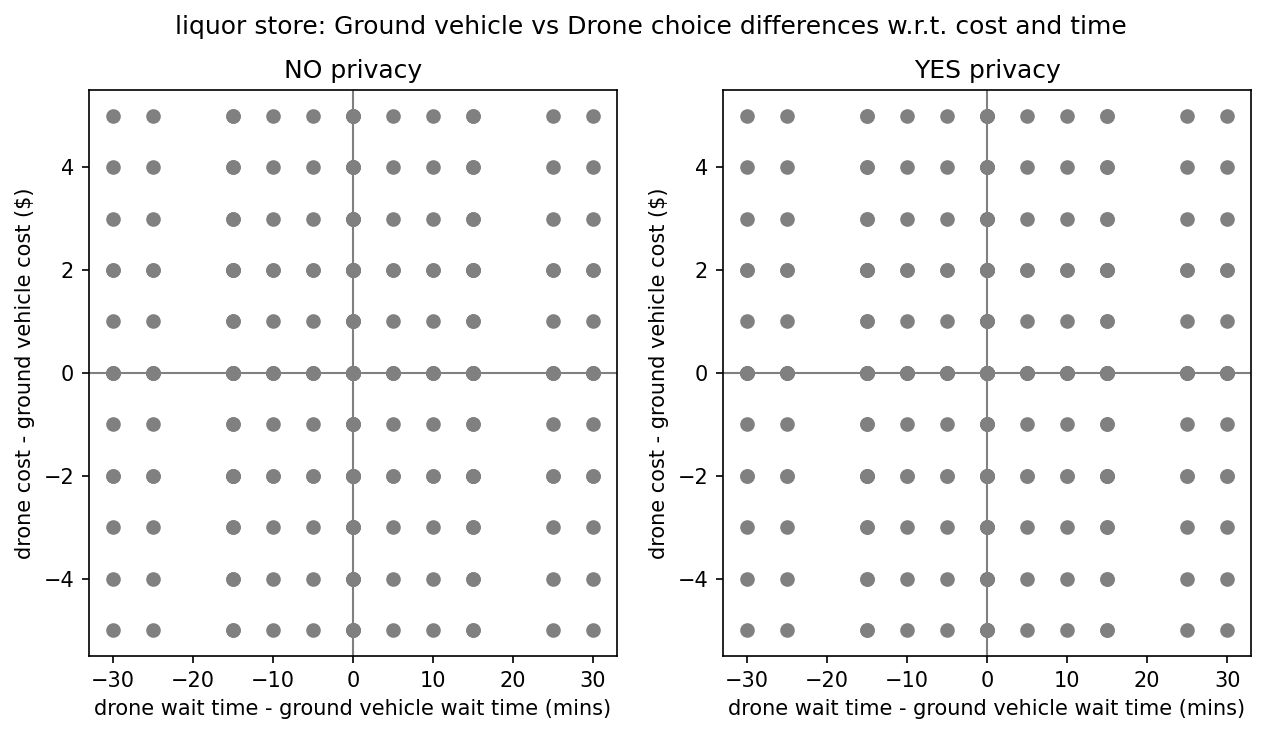

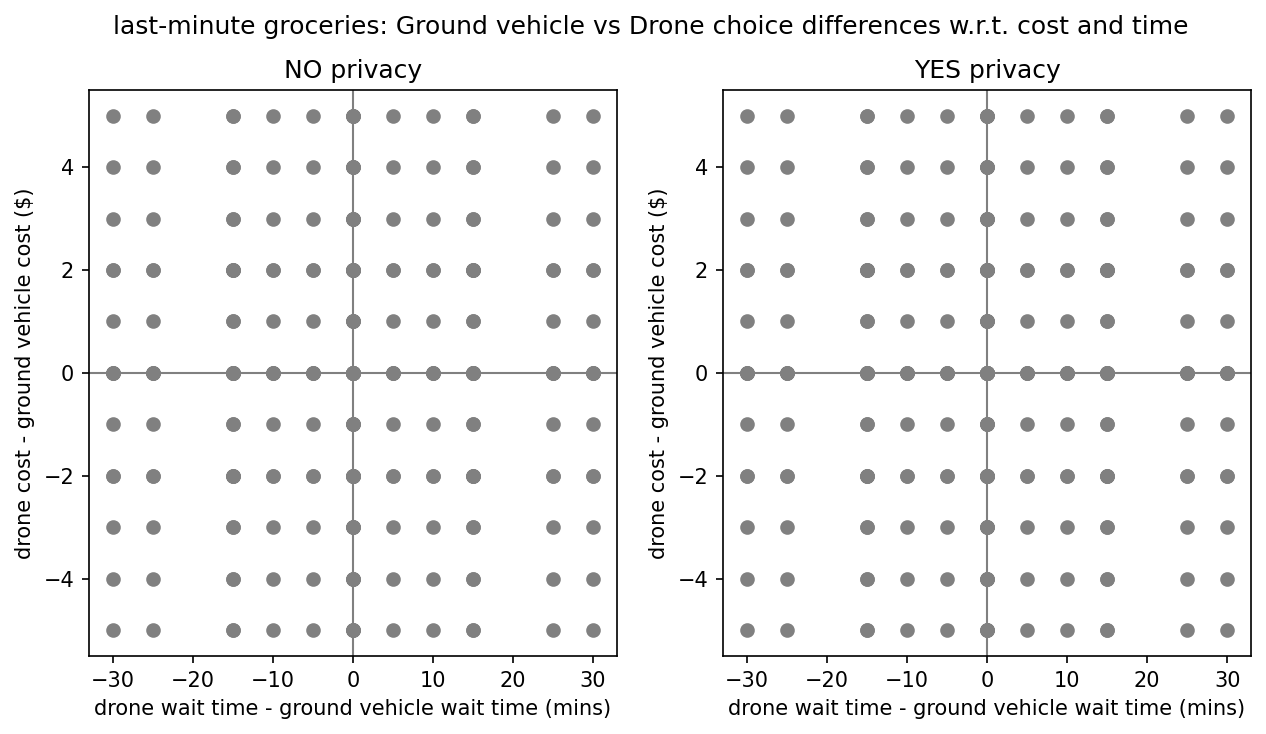

In [17]:
for v, (vendor_type, _) in enumerate(VENDOR_TYPES):
    vdf = df[df['v']==v]
    plot_points_tradeoff(vdf, vendor_type)

### Exclude choices

Exclude a choice if one option is "dominant"

Simply exclude any choices where one alternative dominates the other w.r.t. both cost and time.

take-out food: 368 non-excluded choices
prescription medications: 368 non-excluded choices
liquor store: 368 non-excluded choices
last-minute groceries: 368 non-excluded choices


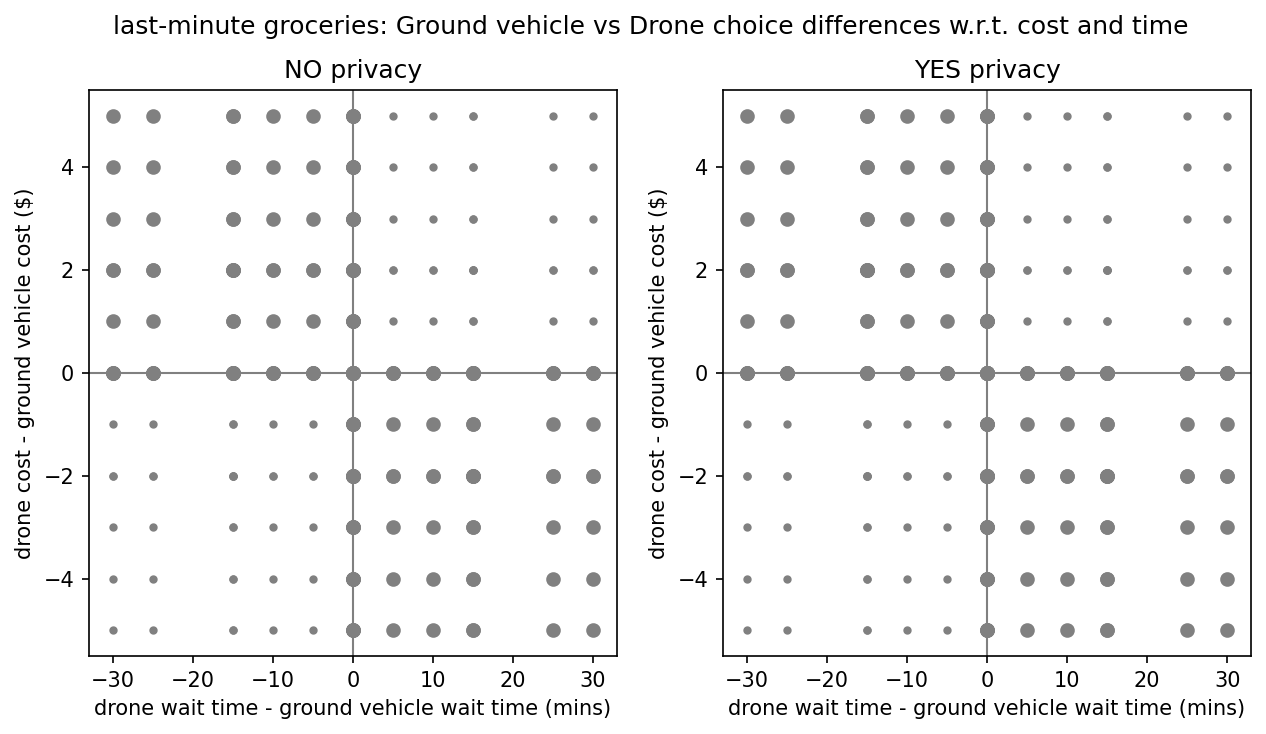

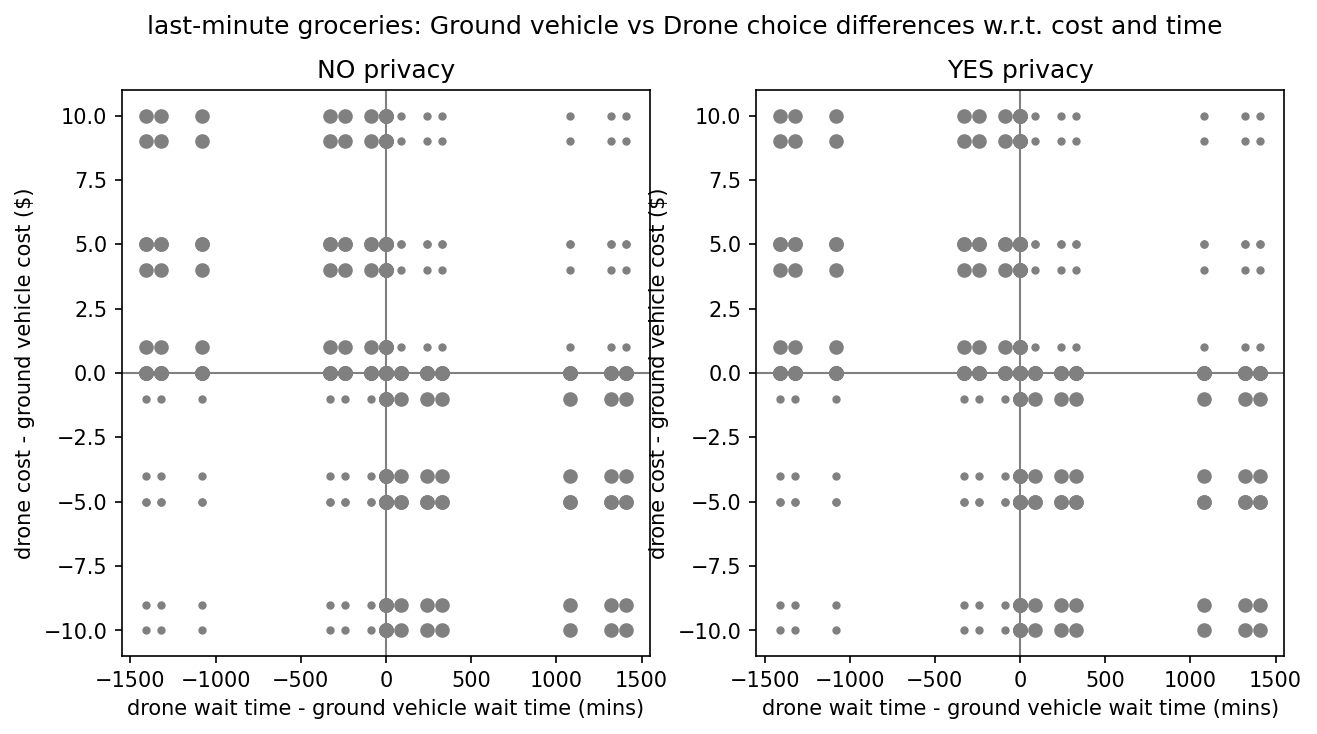

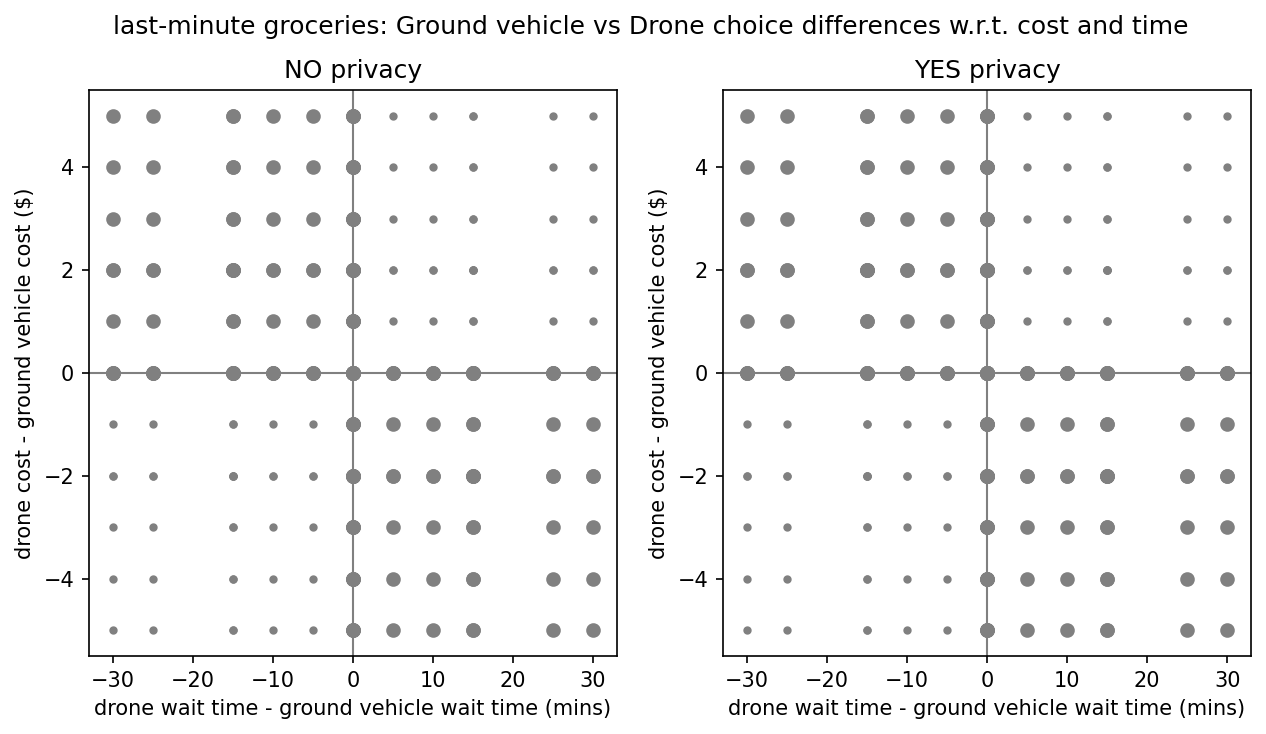

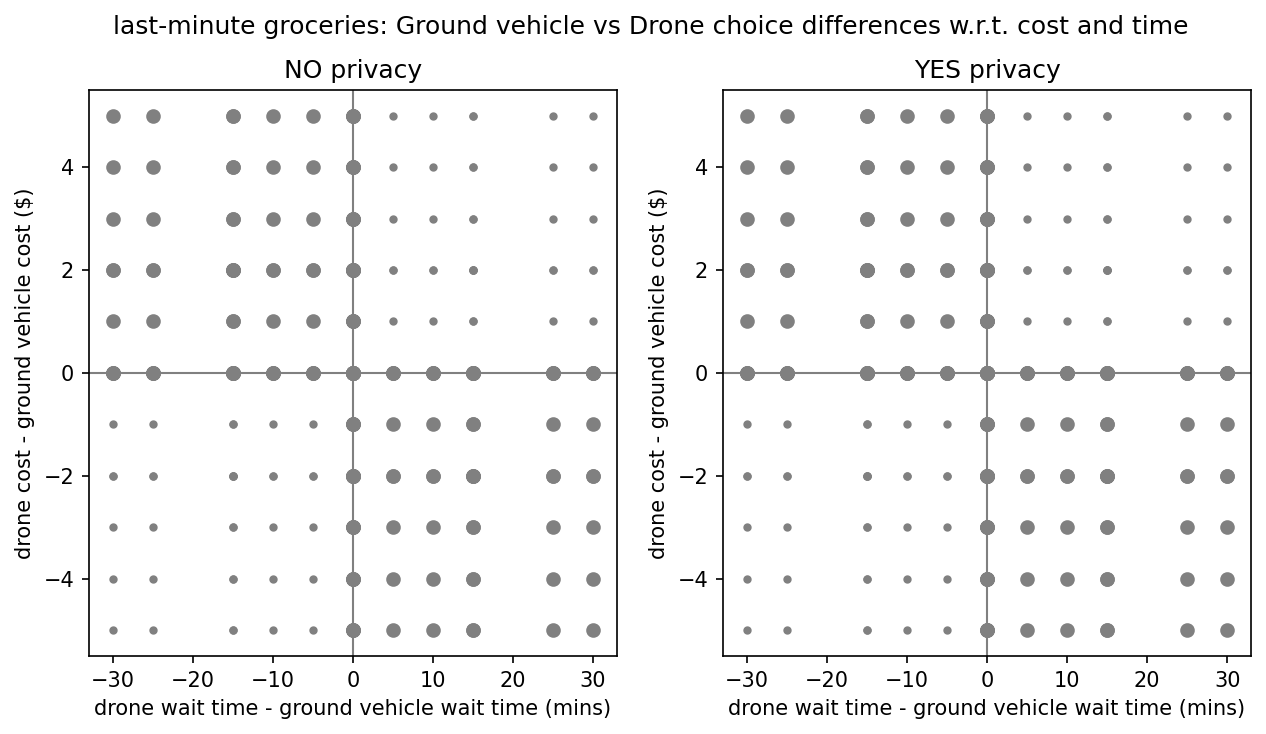

In [18]:
df['exclude'] = (
    ((df['dt'] - df['gt'] > 0) & (df['dc'] - df['gc'] > 0)) | \
    ((df['dt'] - df['gt'] < 0) & (df['dc'] - df['gc'] < 0))
)

for v, (v_type, _) in enumerate(VENDOR_TYPES):
    vdf = df[df['v']==v]
    plot_points_tradeoff(vdf, vendor_type)
    print('%s: %s non-excluded choices' % (v_type, len(vdf[vdf['exclude']==False])))

Randomly sample a subset of non-excluded choices for which to generate choice questions.

Do this separately for vendor types.

In [26]:
CHOICES_SAMPLE_SIZE = 100

In [34]:
df_nonexcluded = df[(df['exclude']==False)]

def sample_v_idx(df, v):
    return np.random.choice(df[df['v']==v].index, CHOICES_SAMPLE_SIZE, replace=False)

sampled_idx = np.concatenate([sample_v_idx(df_nonexcluded, v) for v in range(len(VENDOR_TYPES))])
# print('sampled index: %s' % sampled_idx)
df['sampled'] = df.index.isin(sampled_idx)
print('randomly sampled %s total choices'%len(df[df['sampled']==True]))
df.head()

randomly sampled 400 total choices


,v,v_type,gc,g_cost,gt,g_time,dc,d_cost,dt,d_time,dp,drone privacy,d_time - g_time,d_cost - g_cost,exclude,sampled
0,0,take-out food,0,0,0,15,0,0,0,15,0,0,0,0,False,False
1,0,take-out food,0,0,0,15,0,0,0,15,1,1,0,0,False,False
2,0,take-out food,0,0,0,15,0,0,1,20,0,0,5,0,False,False
3,0,take-out food,0,0,0,15,0,0,1,20,1,1,5,0,False,False
4,0,take-out food,0,0,0,15,0,0,2,30,0,0,15,0,False,True


take-out food: 368 non-excluded choices
100 sampled choices
prescription medications: 368 non-excluded choices
100 sampled choices
liquor store: 368 non-excluded choices
100 sampled choices
last-minute groceries: 368 non-excluded choices
100 sampled choices


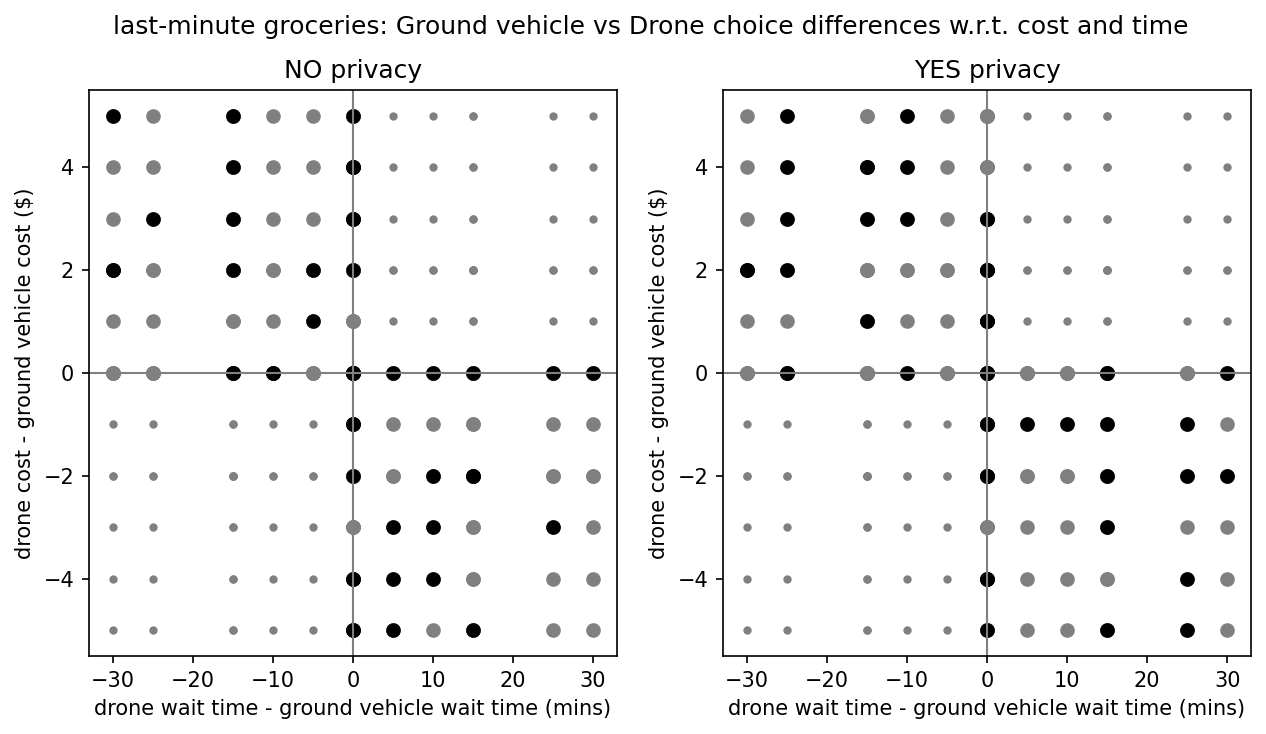

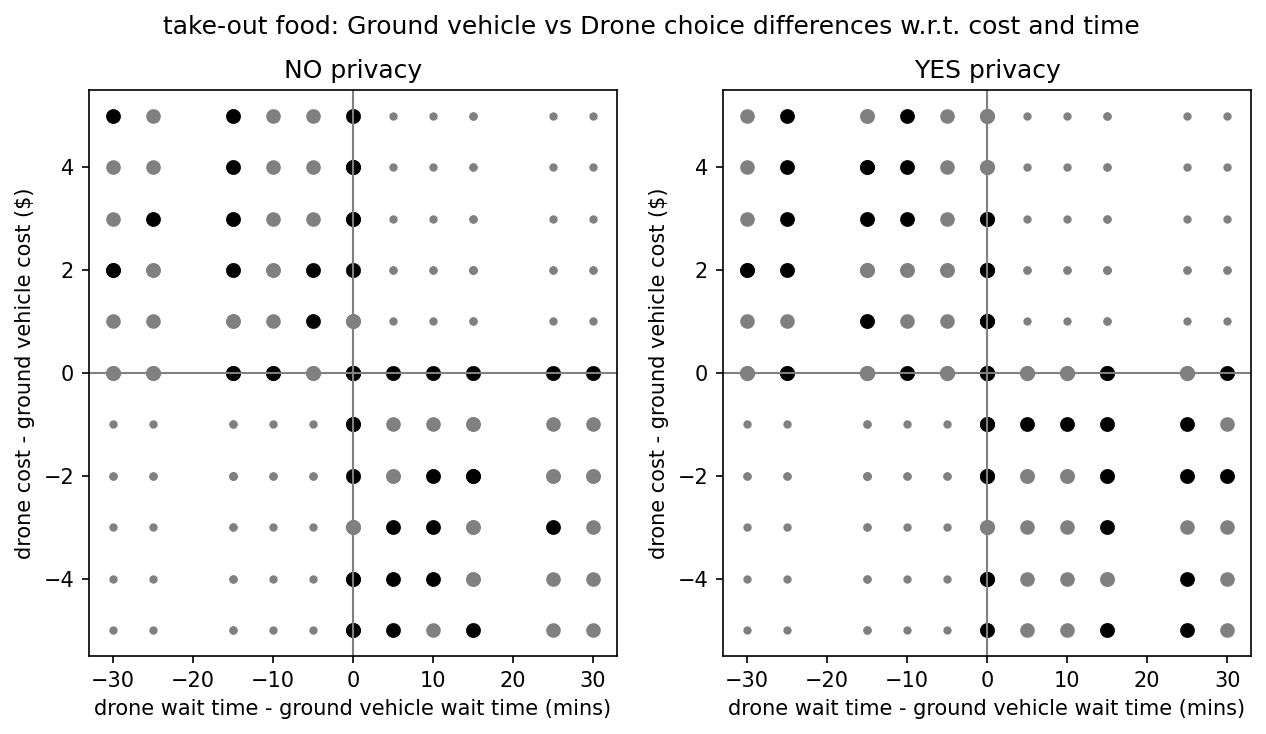

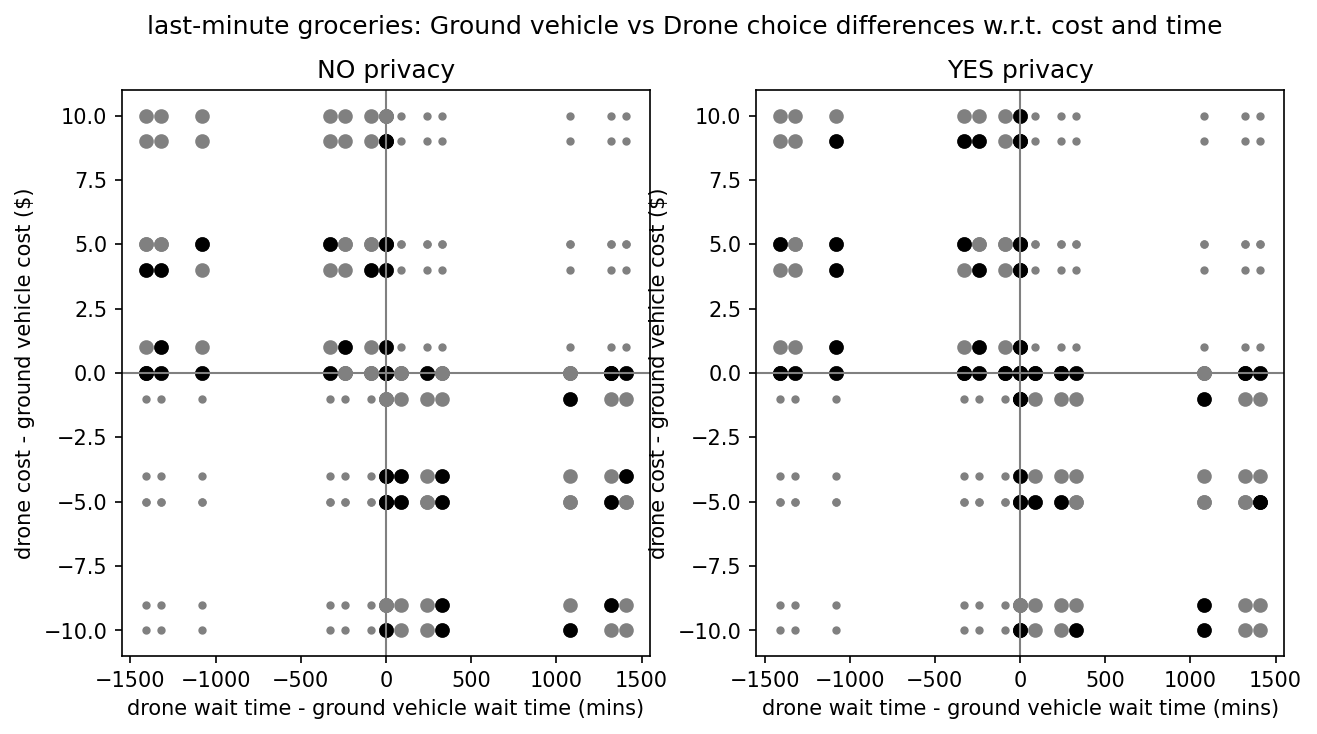

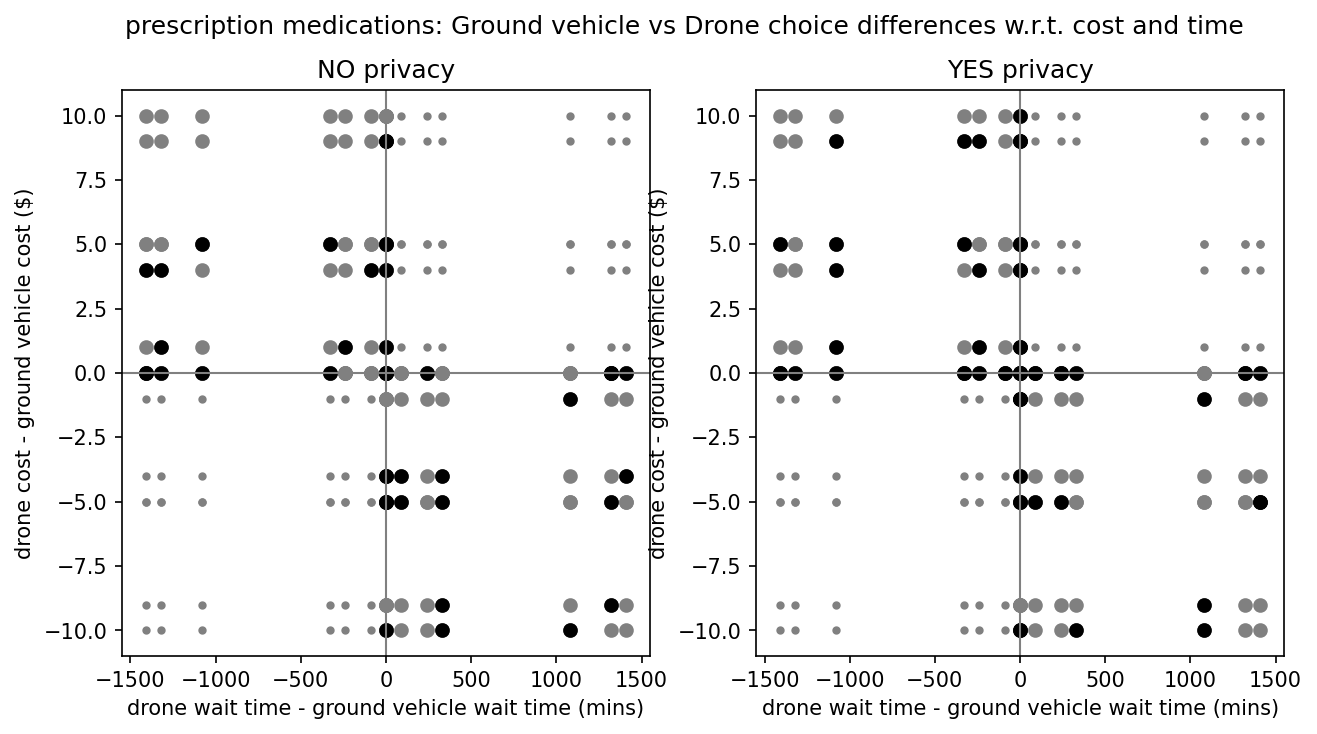

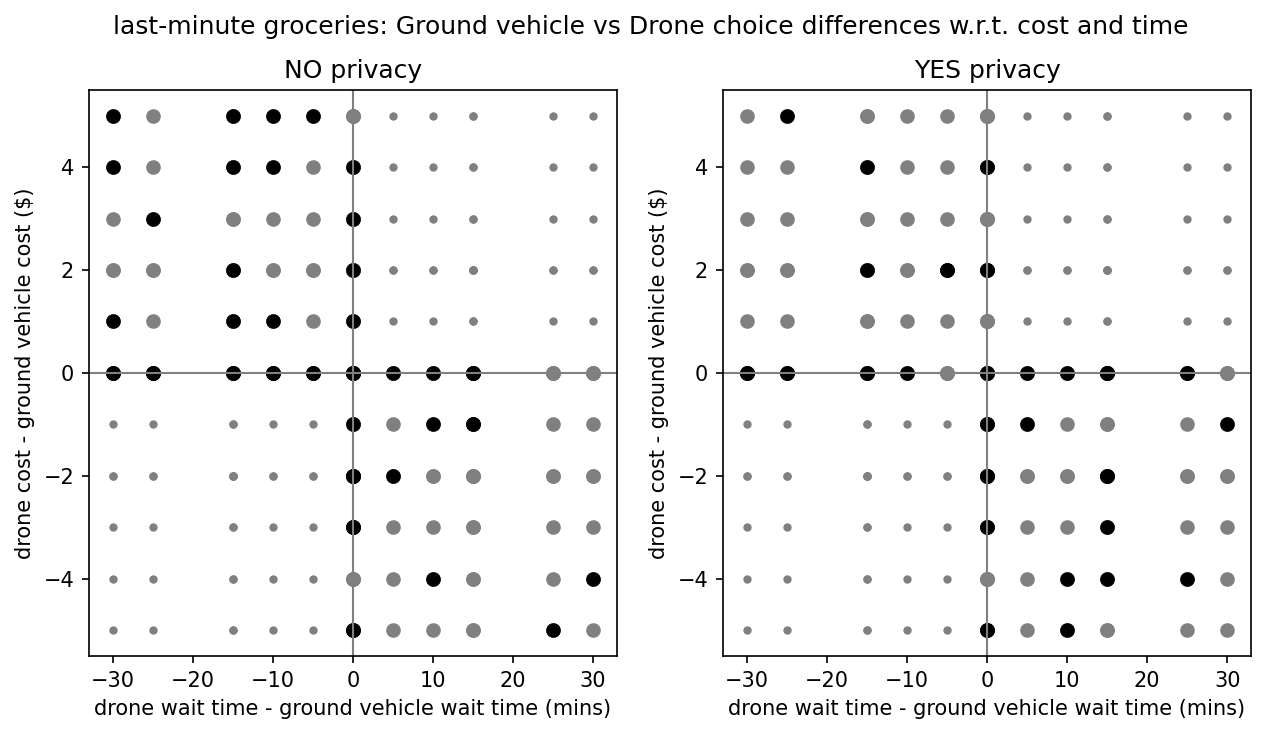

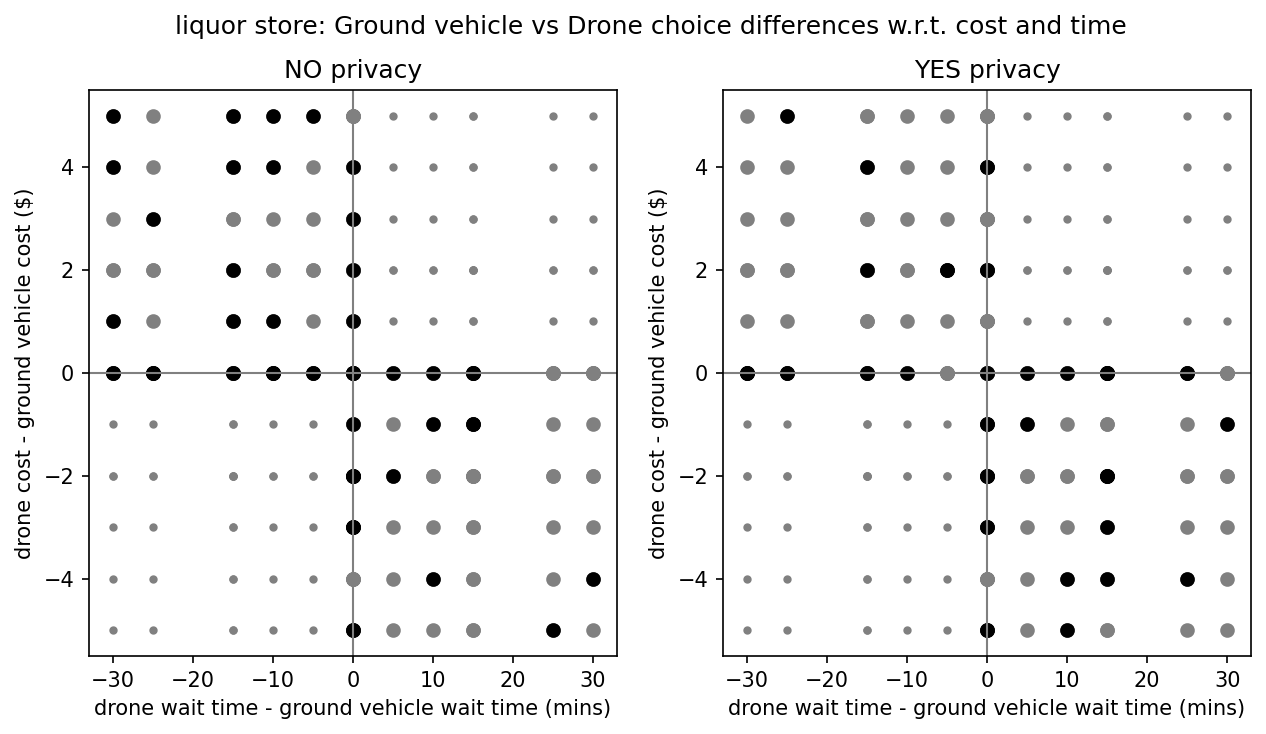

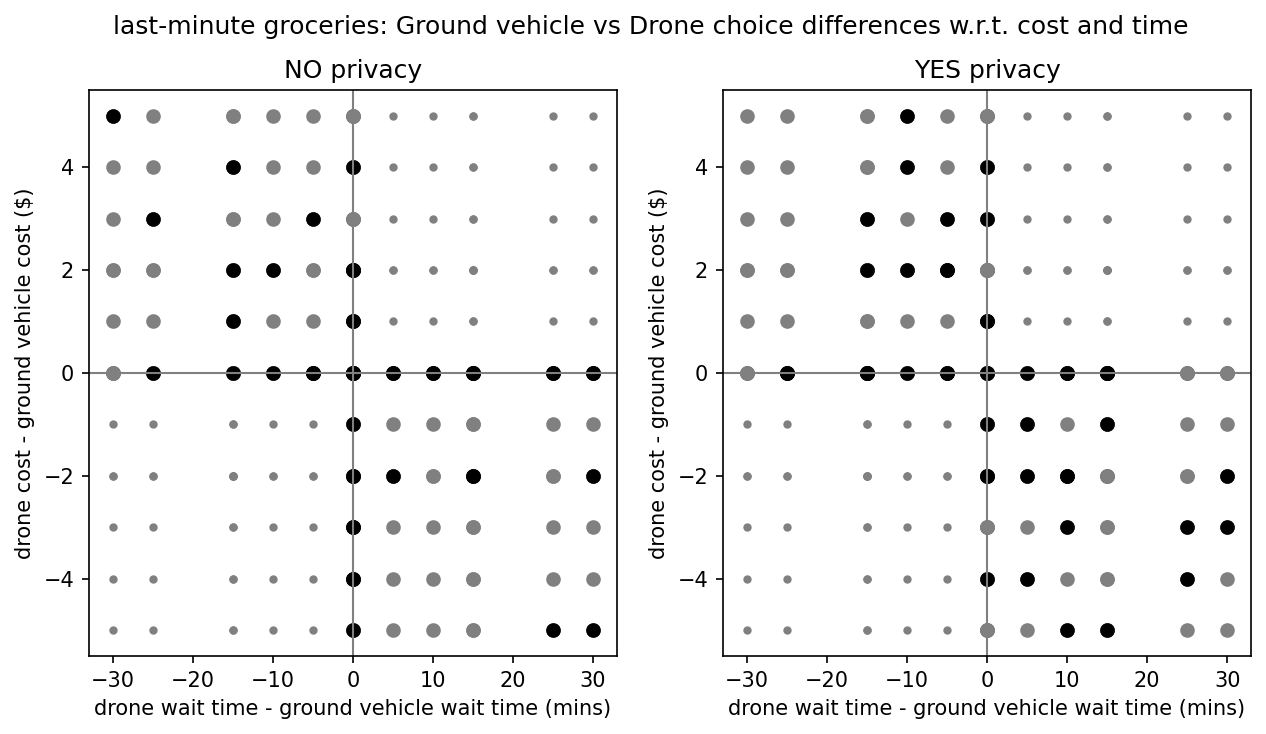

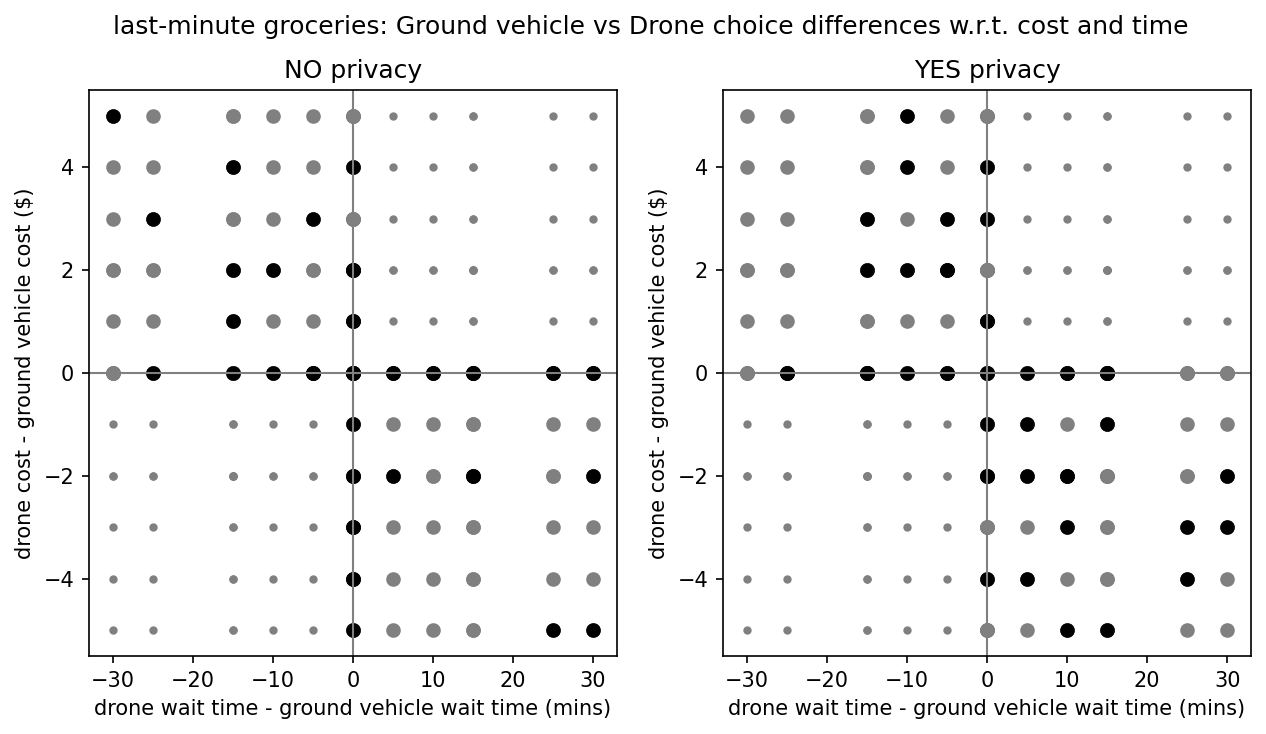

In [35]:
for v, (v_type, _) in enumerate(VENDOR_TYPES):
    vdf = df[df['v']==v]
    plot_points_tradeoff(vdf, vendor_type)
    plot_points_tradeoff(vdf, v_type)
    print('%s: %s non-excluded choices' % (v_type, len(vdf[vdf['exclude']==False])))
    print('%s sampled choices' % len(vdf[vdf['sampled']==True]))

Save choices to file

In [36]:
v_fpath = './choice-sets/surveyv1-choices-vendor%s-sampled-%s.csv'

In [37]:
save_columns = ['v','gc','gt','dt','dc','dp']

for v, (v_type, _) in enumerate(VENDOR_TYPES):
    vdf = df[df['v']==v]
    v_filepath = v_fpath % (
        v, CHOICES_SAMPLE_SIZE
    )
    print('saving %s choices to file for vendor %s: %s to \n%s ...' % (
        CHOICES_SAMPLE_SIZE, v, v_type, v_filepath)
    )
    save_vdf = vdf[vdf['sampled']==True][save_columns]
    save_vdf.to_csv(v_filepath, index=False)
    print('...saved')

saving 100 choices to file for vendor 0: take-out food to 
./choice-sets/surveyv1-choices-vendor0-sampled-100.csv ...
...saved
saving 100 choices to file for vendor 1: prescription medications to 
./choice-sets/surveyv1-choices-vendor1-sampled-100.csv ...
...saved
saving 100 choices to file for vendor 2: liquor store to 
./choice-sets/surveyv1-choices-vendor2-sampled-100.csv ...
...saved
saving 100 choices to file for vendor 3: last-minute groceries to 
./choice-sets/surveyv1-choices-vendor3-sampled-100.csv ...
...saved


In [38]:
test_df = pd.read_csv('./choice-sets/surveyv1-choices-vendor3-sampled-100.csv')
print(len(test_df))
test_df

100


,v,gc,gt,dt,dc,dp
0,3,0,0,1,0,0
1,3,0,0,0,1,0
2,3,0,0,0,1,1
3,3,0,0,0,2,1
4,3,0,1,0,0,1
...,...,...,...,...,...,...
95,3,3,2,3,3,1
96,3,3,3,3,2,0
97,3,3,3,1,3,1
98,3,3,3,2,3,1
